## RBC with Nonlinear Adjustment Costs
In this notebook, I will implement the Real Business Cycle model with nonlinear adjustment costs from Mlikota and Schorfheide (2022) (henceforth *MS*) using the machinery of `DifferentiableStateSpaceModels.jl`. This will enable estimation of the model using the HMC with NUTS algorithm in the probabilistic programming language `Turing.jl`, to establish a baseline for speed and quality comparisons with the proposed methods in *MS*. 

In [1]:
using Pkg; Pkg.instantiate()

In [2]:
using DifferentiableStateSpaceModels, DifferenceEquations, LinearAlgebra, Zygote, Plots, Symbolics

I will implement the model equations following the formulas in *MS* Appendix C, translated into the syntax of `DifferentiableStateSpaceModels.jl`, which follows Schmitt-Grohe and Uribe (2004).

In [3]:
∞ = Inf
# Parameters
@variables α, τ, ν, δ, β, Ystar, Lstar, ϕ_1, ϕ_2, ρ_z, ρ_b, σ_z, σ_b
# x and y
@variables t::Integer, C(..), L(..), Y(..), K(..), b(..), z(..), I(..), Kfu(..), gdp(..), i(..), l(..)
@variables Σ_y, Σ_i, Σ_l
x = [K, z, b]
y = [C, L, I, Y, Kfu, gdp, i, l]
p = [α, τ, ν, δ, β, Ystar, Lstar, ϕ_1, ϕ_2, ρ_z, ρ_b, σ_z, σ_b, Σ_y, Σ_i, Σ_l]

#Define representations for steady state

Kstar = (α / (1 / β - (1 - δ))) * Ystar                             #A.12
Istar = δ * Kstar                                                   #A.13
Cstar = (1 - α * δ / (1 / β - (1 - δ))) * Ystar                     #A.14
Zstar = ((1 / β - (1 - δ)) / α)^α * (Ystar / Lstar)^(1 - α)         #A.15
Bstar = (1 - α) * (Ystar / Lstar) * (Cstar)^(-τ) * (Lstar)^(-1 / ν)


# Model equations
H = [#Labor FOC
    (1 - α) * (Y(t) / L(t)) - Bstar * exp(b(t)) * (C(t))^τ * (L(t))^(1 / ν),
    #Production function
    Y(t) -  Zstar * exp(z(t)) * (K(t))^α * (L(t))^(1 - α),
    #Investment definition
    I(t) - K(t + 1) + (1 - δ) * K(t),
    #Intertemporal budget constraint
    C(t) - Y(t) + I(t) + 
        K(t) * ϕ_1 * (exp(-ϕ_2 * (K(t + 1) / K(t) - 1)) + ϕ_2 * (K(t + 1) / K(t) - 1) - 1) / (ϕ_2)^2,
    #Euler equation
    C(t)^(-τ) * (1 + (ϕ_1 / ϕ_2) * (1 - exp(-ϕ_2 * (K(t + 1) / K(t) - 1)))) -
        β * C(t+1)^(-τ) * (α * (Y(t + 1) / K(t + 1)) + 1 - δ -  ϕ_1 * (exp(-ϕ_2 * (Kfu(t + 1) / K(t + 1) - 1)) + ϕ_2 * (Kfu(t + 1) / K(t + 1) - 1) - 1) / (ϕ_2)^2 +  
        (Kfu(t + 1) / K(t + 1)) * (ϕ_1 / ϕ_2) * (1 - exp(-ϕ_2 * (Kfu(t + 1) / K(t + 1) - 1)))),
    #Auxiliary future variable
    Kfu(t) - K(t + 1), 
    #TFP Shock
    z(t + 1) - ρ_z * z(t),
    #Laziness shock
    b(t + 1) - ρ_b * b(t),
    #logarithms for observation
    exp(gdp(t)) - Y(t),
    exp(i(t)) - I(t),
    exp(l(t)) - L(t)]   
    
    
#Steady state values
#Use as initial conditions (_iv) to test, but if correct change to analytical    
steady_states = [K(∞) ~ Kstar, Kfu(∞) ~ Kstar,
                    C(∞) ~ Cstar, I(∞) ~ Istar,
                    Y(∞) ~ Ystar, L(∞) ~ Lstar,
                    z(∞) ~ 0, b(∞) ~ 0,
                    gdp(∞) ~ log(Ystar), i(∞) ~ log(Istar), l(∞) ~ log(Lstar)] 

n_ϵ = 2
n_x = length(x)
n_y = length(y)
#Shock standard deviations
Γ = zeros(Num, n_ϵ, n_ϵ) # make sure it is not a float64 matrix
Γ[1, 1] = σ_z
Γ[2, 2] = σ_b
#Map from shocks to x equations
η = zeros(n_x, n_ϵ) # η is n_x * n_ϵ matrix
η[2, 1] = 1 # z
η[3, 2] = 1 # b

n_z = 3 # number of observables
Q = zeros(n_z, n_x + n_y) # the order is [y, x]
Q[1, 6] = 1.0 # gdp 
Q[2, 7] = 1.0 # i
Q[3, 8] = 1.0 # l

Ω = [Σ_y, Σ_i, Σ_l]
    
# Generates the files and includes if required.
overwrite_model_cache  = true
  
model_MS_1 = make_perturbation_model(H; t, y, x, p, steady_states, Γ, Ω, η, Q, 
    overwrite_model_cache, max_order = 1, model_name="MSorder1") 

Building model up to order 1
Substituting and simplifying
Building model functions
Saved MSorder1 to /Users/dchilder/.julia/packages/DifferentiableStateSpaceModels/Rj4ZG/.function_cache/MSorder1.jl


"/Users/dchilder/.julia/packages/DifferentiableStateSpaceModels/Rj4ZG/.function_cache/MSorder1.jl"

In [4]:
include("/Users/dchilder/.julia/packages/DifferentiableStateSpaceModels/Rj4ZG/.function_cache/MSorder1.jl")
model_MS_1 = DifferentiableStateSpaceModels.PerturbationModel(getfield(Main, Symbol("MSorder1")))

Perturbation Model: n_y = 8, n_x = 3, n_p = 16, n_ϵ = 2, n_z = 3
 y = [:C, :L, :I, :Y, :Kfu, :gdp, :i, :l] 
 x = [:K, :z, :b] 
 p = [:α, :τ, :ν, :δ, :β, :Ystar, :Lstar, :ϕ_1, :ϕ_2, :ρ_z, :ρ_b, :σ_z, :σ_b, :Σ_y, :Σ_i, :Σ_l]

In [5]:
#Solve at a point: note extra parameters
#Fixed Parameters
p_f = (; Ystar = 1.0, Lstar = 1.0, δ = 0.08, β = 1/((3.0/400)+1), Σ_y = 0.006, Σ_i = 0.004, Σ_l = 0.004)
#Parameters to estimate
p_d = (; α = 0.35, τ = 2.0, ν = 1.0, ϕ_1 = 50.0, ϕ_2 = 200.0, ρ_z = 0.95, ρ_b = 0.90, σ_z = 0.02, σ_b = 0.016)
cache = SolverCache(model_MS_1, Val(1), p_d)   # the p_d passed into the cache just reuses the symbols, and the values in p_d are unused

sol = generate_perturbation(model_MS_1, p_d, p_f; cache) # Solution to the first-order model
@show sol.retcode

sol.retcode = :Success


:Success

In [6]:
#Check numerical steady state: basic unit test
verify_steady_state(model_MS_1, p_d, p_f)

true

In [7]:
#Let's create code to see where steady state may have issues
#Modify code to fix bugs and return more informative output
order_vector_by_symbols(x, symbols) = [x[sym] for sym in symbols]
function steady_state_mat(m, p_d, p_f; args...)
    sol = generate_perturbation(m, p_d, p_f; args...)
    p_d_symbols = collect(Symbol.(keys(p_d)))
    p = order_vector_by_symbols(merge(p_d, p_f), m.mod.m.p_symbols)
    w = vcat(sol.y, sol.x) # get a vector for the proposed steadystate
    Hnew = Vector{Float64}(undef, length(w)) # allocate it, but leave undef to make sure we can see if it goes to 0 or not
    m.mod.m.H̄!(Hnew, w, p)  # evaluate in place
    return Hnew
end
ss = steady_state_mat(model_MS_1, p_d, p_f)

11-element Vector{Float64}:
 -1.1102230246251565e-16
  2.220446049250313e-16
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  5.551115123125783e-17
  0.0

First pass: OK, error seems to be in my equation 4, which is the budget constraint. My formula for steady state C satisfies $C^* = Y^* - I^*$, while equation 4 also includes an adjustment cost term. These will require reconciliation if the adjustment cost term is non-zero in steady state.  Per equation (24), the adjustment cost should be zero in steady state, which is a good indication that I messed up the very ugly formula. Oh, yup, I had a sign error. It should be fixed on the rerun.

Next pass: all zeros means it looks fine.

In [8]:
model_H_latex(model_MS_1) #Display model formulas

"\$\\begin{equation}\n\\left[\n\\begin{array}{c}\n\\frac{\\left( 1 - \\alpha \\right) Y\\left( t \\right)}{L\\left( t \\right)} + \\frac{ - \\left( L\\left( t \\right) \\right)^{\\frac{1}{\\nu}} \\left( C\\left( t \\right) \\right)^{\\tau} \\left( Ystar \\left( 1 + \\frac{ - \\alpha \\delta}{-1 + \\delt" ⋯ 1652 bytes ⋯ "eft( 1 + t \\right) \\\\\n - \\rho_{b} b\\left( t \\right) + b\\left( 1 + t \\right) \\\\\n - Y\\left( t \\right) + e^{\\mathrm{gdp}\\left( t \\right)} \\\\\n - I\\left( t \\right) + e^{i\\left( t \\right)} \\\\\n - L\\left( t \\right) + e^{l\\left( t \\right)} \\\\\n\\end{array}\n\\right]\n\\end{equation}\n\$"

In [9]:
#Generate IRFs to TFP and Laziness shocks 
T = 40
ϵ01 = [1.0, 0.0]
ϵ02 = [0.0, 1.0]
val1 = irf(sol, ϵ01, T) #TFP shock

retcode: Success
Interpolation: Piecewise constant interpolation
t: 0:40
u: 41-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0]
 [0.0, 0.02, 0.0]
 [0.002412795883079372, 0.019, 5.322698121470713e-20]
 [0.004640113867046079, 0.01805, 9.846991524720677e-20]
 [0.006692970215484664, 0.0171475, 1.3666027426875654e-19]
 [0.008581783556820665, 0.016290125, 1.6862972986083646e-19]
 [0.010316406024307025, 0.015475618749999998, 1.9512046574275929e-19]
 [0.011906152805199306, 0.014701837812499997, 2.1679444259308822e-19]
 [0.013359830179568875, 0.013966745921874996, 2.3424172058715273e-19]
 [0.014685762125156382, 0.013268408625781245, 2.4798793466914093e-19]
 [0.015891815560823915, 0.012604988194492182, 2.585010080358939e-19]
 [0.016985424297513253, 0.011974738784767573, 2.661971807242871e-19]
 [0.017973611762149688, 0.011376001845529194, 2.7144642246924077e-19]
 ⋮
 [0.023845409930936153, 0.004756537705106643, 1.9746371381281937e-19]
 [0.02377844943528422, 0.0045187108198513105, 1.90376149585361

In [10]:
val2 = irf(sol, ϵ02, T) #laziness shock

retcode: Success
Interpolation: Piecewise constant interpolation
t: 0:40
u: 41-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.016]
 [-0.0006414337265629234, -3.291581277533176e-19, 0.014400000000000003]
 [-0.0012014870868313464, -6.079659444093142e-19, 0.012960000000000005]
 [-0.0016887613203150473, -8.423564495607904e-19, 0.011664000000000006]
 [-0.002110985095105893, -1.0376237391841663e-18, 0.010497600000000006]
 [-0.0024751020995154626, -1.1984891951354203e-18, 0.009447840000000008]
 [-0.0027873498655601354, -1.3291609402304432e-18, 0.008503056000000009]
 [-0.003053330701350448, -1.4333872381383516e-18, 0.0076527504000000095]
 [-0.003278075521729354, -1.5145044491037356e-18, 0.0068874753600000095]
 [-0.0034661012875632394, -1.5754800911369884e-18, 0.006198727824000009]
 [-0.003621462693043021, -1.6189515010865136e-18, 0.005578855041600009]
 [-0.003747798676410924, -1.647260540316841e-18, 0.005020969537440008]
 ⋮
 [-0.0036318894470161985, -1.1386857305025516e-18, 0.

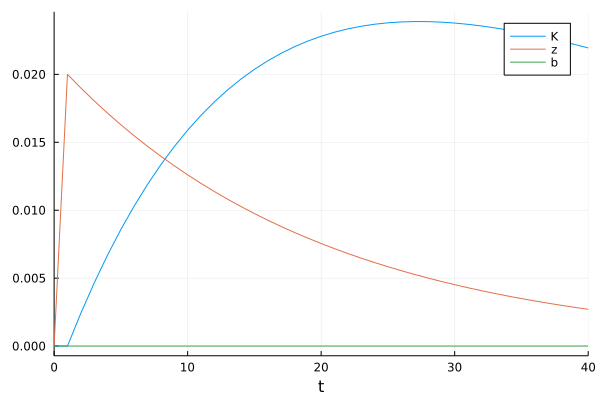

In [11]:
plot(val1)

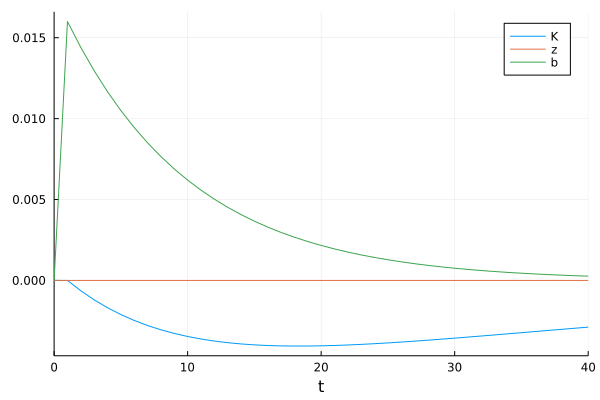

In [12]:
plot(val2)

Above checks look good enough: no obvious problems with the model.
Now simulate it.

In [13]:
using Distributions, Turing, Random

In [14]:
using Turing: @addlogprob!
Turing.setadbackend(:zygote);

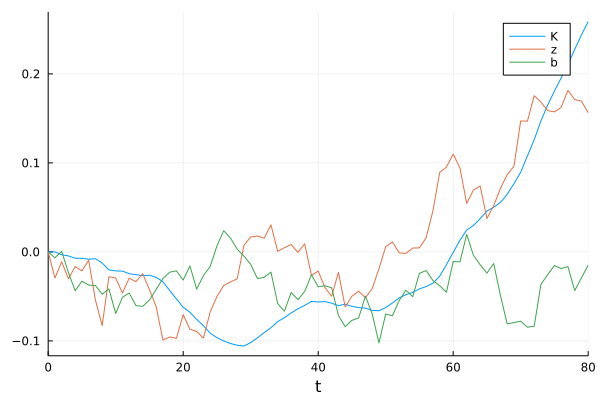

In [15]:
# Simulate T observations from a random initial condition
T = 80
Random.seed!(12345) #Fix seed to reproduce data
x_iv = zeros(n_x) #Start from steady state
# Alternately, draw from ergodic distribution for the initial condition
#x_iv = MvNormal(sol.x_ergodic_var)
problem = LinearStateSpaceProblem(sol, x_iv, (0, T))
sim = solve(problem, DirectIteration())
plot(sim)

In [16]:
#Generate data for estimation
ϵ = sim.W # store the underlying noise in the simulation
# Collapse to simulated observables as a matrix  - as required by current DifferenceEquations.jl likelihood
# see https://github.com/SciML/DifferenceEquations.jl/issues/55 for direct support of this datastructure
z_ms = hcat(sim.z...)

3×81 Matrix{Float64}:
 -0.000295036  -0.0156423  …   0.14525     0.143564    0.130908
 -0.00319411   -0.0165479      0.110744    0.11127     0.103163
  0.000161469   0.0176656     -0.0760915  -0.0688861  -0.0713125

In [28]:
#Convert priors from mean-sd to distributions.jl parameterizations using utilities
function Beta_tr(mu, sd)
    a = ((1 - mu) / sd^2 - 1 / mu) * mu^2
    b = a * (1 / mu - 1)
    return a, b
end

function Gamma_tr(mu, sd)
    b = sd^2 / mu
    a = mu / b
    return a, b
end

function InvGamma_tr(mu, sd)
    a = mu^2 / sd^2 + 2
    b = mu * (a - 1)
    return a, b
end

InvGamma_tr (generic function with 1 method)

In [46]:
#Priors for MS Table 2
(τ1, τ2) = Gamma_tr(1.0,1.0)
(ν1, ν2) = Gamma_tr(0.5,0.3)
(α1, α2) = Beta_tr(0.35,0.05)
(ϕ11, ϕ12) = Gamma_tr(30.0,15.0)
(ρz1, ρz2) = Beta_tr(0.6, 0.15)
(ρb1, ρb2) = Beta_tr(0.6, 0.15)
(sz1, sz2) = InvGamma_tr(1.50,5.0)
(sb1, sb2) = InvGamma_tr(1.50,5.0)
priorparam = (; τ1, τ2, ν1, ν2, α1, α2, ϕ11, ϕ12, ρz1, ρz2, ρb1, ρb2, sz1, sz2, sb1, sb2) 

(τ1 = 1.0, τ2 = 1.0, ν1 = 2.7777777777777777, ν2 = 0.18, α1 = 31.499999999999993, α2 = 58.499999999999986, ϕ11 = 4.0, ϕ12 = 7.5, ρz1 = 5.8, ρz2 = 3.866666666666667, ρb1 = 5.8, ρb2 = 3.866666666666667, sz1 = 2.09, sz2 = 1.6349999999999998, sb1 = 2.09, sb2 = 1.6349999999999998)

In [48]:
# Turing model definition
@model function ms_kalman(z, m, p_f, cache, settings, priorparam)
    
    # priors
    τ ~ Gamma(priorparam[:τ1], priorparam[:τ2])
    ν ~ Gamma(priorparam[:ν1], priorparam[:ν2])
    α ~ Beta(priorparam[:α1], priorparam[:α2])
    ϕ_1 ~ Gamma(priorparam[:ϕ11], priorparam[:ϕ12])
    ϕ_2 ~ Normal(0.0, 75.0)
    ρ_z ~ Beta(priorparam[:ρz1], priorparam[:ρz2])
    ρ_b ~ Beta(priorparam[:ρb1], priorparam[:ρb2])
    s_z ~ InverseGamma(priorparam[:sz1], priorparam[:sz2])
    s_b ~ InverseGamma(priorparam[:sb1], priorparam[:sb2])
    σ_z = s_z/100
    σ_b = s_b/100
    p_d = p_d = (; α, τ, ν, ϕ_1, ϕ_2, ρ_z, ρ_b, σ_z, σ_b)
    T = size(z, 2)
    # also passes in the p_f for fixed values
    sol = generate_perturbation(m, p_d, p_f, Val(1); cache, settings) # first-order perturbation
    if !(sol.retcode == :Success) # if the perturbation failed, we want to return -infinity for the likelihood and resample
        @addlogprob! -Inf
        return
    end
    x_iv = zeros(sol.n_x) #Replace with ~ MvNormal(sol.x_ergodic_var) to start at ergodic
    problem = LinearStateSpaceProblem(sol, x_iv, (0, T), observables = z) # utility constructs a LinearStateSpaceProblem from the sol.A, sol.B, etc.
    @addlogprob! solve(problem, KalmanFilter()).logpdf # Linear-Gaussian so can marginalize with kalman filter.  It should automatically choose the KalmanFilter in this case if not provided.
end
settings = PerturbationSolverSettings(; print_level = 0)
p_f = (; Ystar = 1.0, Lstar = 1.0, δ = 0.08, β = 1/((3.0/400)+1), Σ_y = 0.006, Σ_i = 0.004, Σ_l = 0.004) # Fixed parameters
z = z_ms # simulated in previous steps
turing_model = ms_kalman(z, model_MS_1, p_f, cache, settings, priorparam) # passing observables from before 

DynamicPPL.Model{typeof(ms_kalman), (:z, :m, :p_f, :cache, :settings, :priorparam), (), (), Tuple{Matrix{Float64}, PerturbationModel{1, true, Matrix{Float64}, Matrix{Float64}}, NamedTuple{(:Ystar, :Lstar, :δ, :β, :Σ_y, :Σ_i, :Σ_l), NTuple{7, Float64}}, SolverCache{1, Vector{Float64}, Vector{Vector{Float64}}, Matrix{Float64}, Matrix{Float64}, Nothing, Nothing}, PerturbationSolverSettings{Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, NamedTuple{(:τ1, :τ2, :ν1, :ν2, :α1, :α2, :ϕ11, :ϕ12, :ρz1, :ρz2, :ρb1, :ρb2, :sz1, :sz2, :sb1, :sb2), NTuple{16, Float64}}}, Tuple{}, DynamicPPL.DefaultContext}(ms_kalman, (z = [-0.00029503556271616026 -0.015642292835239123 … 0.14356433984906178 0.1309077372946595; -0.003194107027880543 -0.016547855320962826 … 0.1112697350151692 0.10316334659768465; 0.00016146878012521167 0.017665617613017354 … -0.06888610951746088 -0.07131246127747957], m = PerturbationModel{1, true, Matrix{Float64}, Matrix{Float64}}(DifferentiableStateSpaceModels.ModuleWrapper(Ma

In [50]:
n_samples = 2000
n_adapts = 200
δ = 0.65
alg = NUTS(n_adapts,δ)
println("Sampling.  Ignore any 'rejected due to numerical errors' warnings")  # At this point, Turing can't turn off those warnings
chain_1_marginal = sample(turing_model, alg, n_samples; progress = true)

Sampling.  Ignore any 'rejected due to numerical errors' warnings


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /Users/dchilder/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /Users/dchilder/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/dchilder/.julia/packages/Turing/Tpj0b/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/dchilder/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 15:08:07


Chains MCMC chain (2000×21×1 Array{Float64, 3}):

Iterations        = 201:1:2200
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 54491.66 seconds
Compute duration  = 54491.66 seconds
parameters        = τ, ν, α, ϕ_1, ϕ_2, ρ_z, ρ_b, s_z, s_b
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

           τ    3.6597    0.1763     0.0039    0.0264    4.2895    2.8247      ⋯
           ν    0.1742    0.0066     0.0001    0.0010    4.4625    1.8266      ⋯
           α    0.6805    0.0083     0.0002    0.0013    4.6329    1.8255      ⋯
         ϕ_1   15.2047    0.4594     0.0103    0.0640    5.6177    1.4991      ⋯
         ϕ_2   -1.6066    0.0

In [28]:
#Add visualization package if needed
#import Pkg; Pkg.add("StatsPlots")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed StatsPlots ──────── v0.15.3
   Installed HDF5_jll ────────── v1.12.2+2
   Installed MultivariateStats ─ v0.10.0
   Installed NearestNeighbors ── v0.4.11
    Updating `~/Dropbox/Differentiable Programming/HMCSGU/HMCExamples.jl/Project.toml`
  [f3b207a7] + StatsPlots v0.15.3
    Updating `~/Dropbox/Differentiable Programming/HMCSGU/HMCExamples.jl/Manifest.toml`
  [7d9fca2a] + Arpack v0.5.3
  [aaaa29a8] + Clustering v0.14.2
  [e7dc6d0d] + DataValues v0.4.13
  [6f286f6a] + MultivariateStats v0.10.0
  [b8a86587] + NearestNeighbors v0.4.11
  [510215fc] + Observables v0.5.1
  [f3b207a7] + StatsPlots v0.15.3
  [ab02a1b2] + TableOperations v1.2.0
  [cc8bc4a8] + Widgets v0.6.6
  [68821587] + Arpack_jll v3.5.1+1
  [0234f1f7] ↑ HDF5_jll v1.12.2+1 ⇒ v1.12.2+2
Precompiling project...
  ✓ Observables
  ✓ HDF5_jll
  ✓ TableOperations
  ✓ Arpack_jll
  ✓ Arpack
  ✓ DataValues
  ✓ NearestNeighbors
  

In [19]:
using StatsPlots

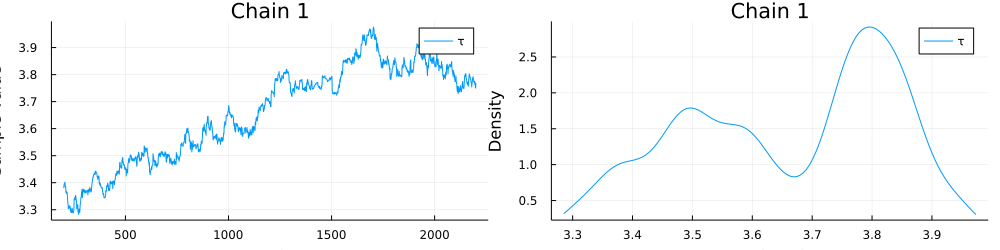

In [51]:
plot(chain_1_marginal[["τ"]]; colordim=:parameter, legend=true)

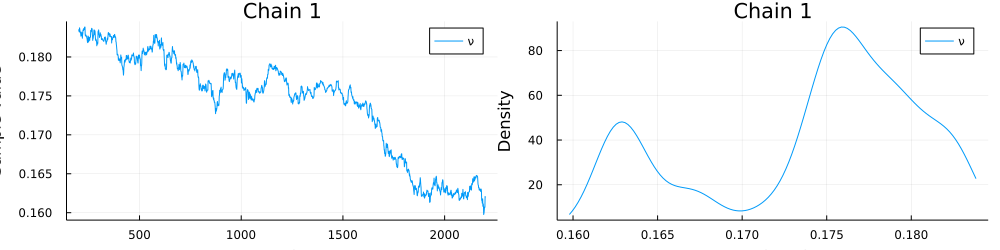

In [52]:
plot(chain_1_marginal[["ν"]]; colordim=:parameter, legend=true)

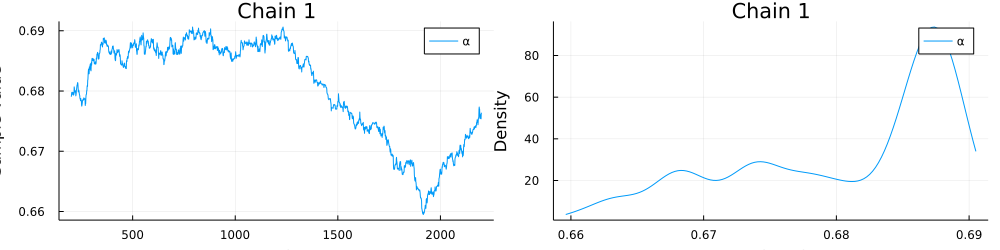

In [53]:
plot(chain_1_marginal[["α"]]; colordim=:parameter, legend=true)

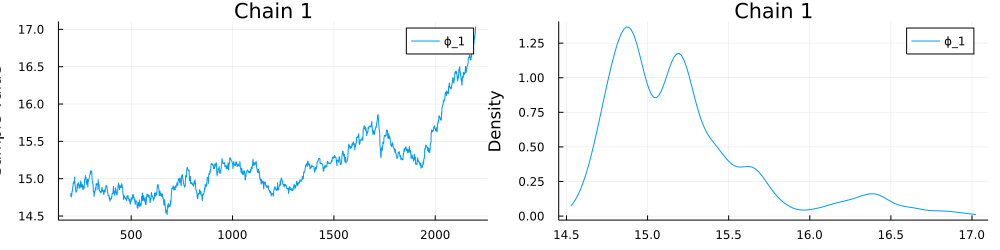

In [54]:
plot(chain_1_marginal[["ϕ_1"]]; colordim=:parameter, legend=true)

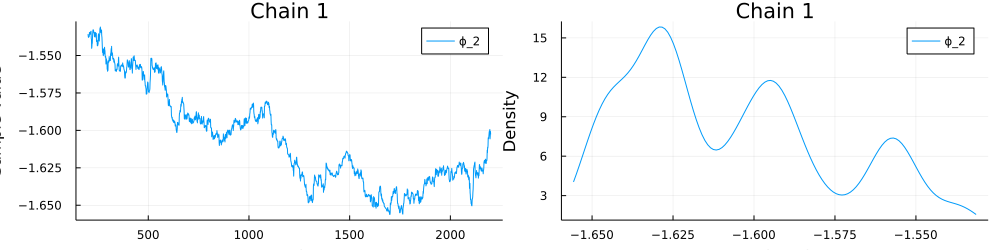

In [55]:
plot(chain_1_marginal[["ϕ_2"]]; colordim=:parameter, legend=true)

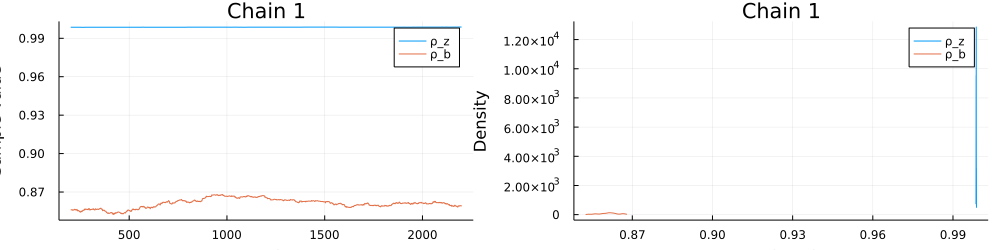

In [56]:
plot(chain_1_marginal[["ρ_z", "ρ_b"]]; colordim=:parameter, legend=true)

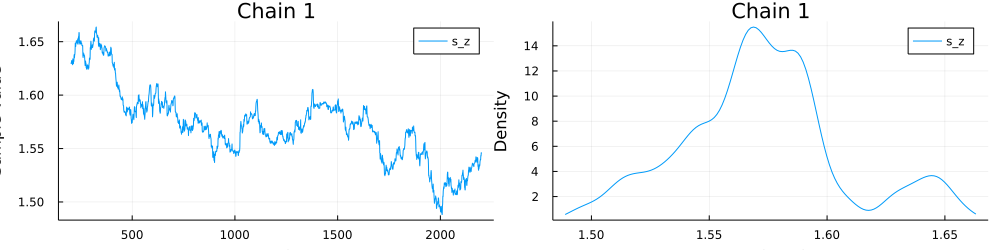

In [57]:
plot(chain_1_marginal[["s_z"]]; colordim=:parameter, legend=true)

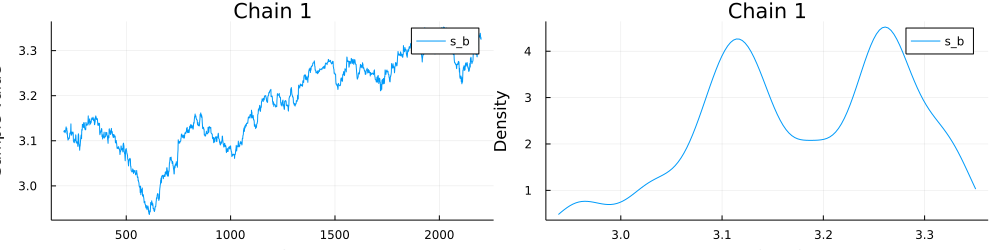

In [58]:
plot(chain_1_marginal[["s_b"]]; colordim=:parameter, legend=true)

Alright. The sampler works. 

With a small run size it's noisy and possibly off the simulated true values, but maybe by an amount that looks fixable with a decent size run, and it's not super fast, so it could probably stand some optimizations, but that's fine. 

With a larger run size, we start to see problems. First, it takes 15979.46 seconds, or about 4.5 hours, to draw 2000 samples, which is very bad. Mixing looks poor, based on Rhat and the traceplots, and several of the estimates are very far from the pseudo-true values. 
- This might reflect bugs in the model, but note that any issues with the equations also affect the simulations, so errors in the equations themselves wouldn't necessarily destroy the estimation quality. 
- Bad priors might, if they are far from the truth. An important thing for me to check will be whether I am using the wrong parameterizations for some distributions (eg, my $\alpha$ estimates are nowhere close, when the prior should be starting it near the truth.)
    - Update, yup, MS use mean-variance parameterizations, while `Distributions.jl` uses other ones, so my prior choices are all wrong. That would explain $alpha$, and contribute to some of the others.
- The $phi$ estimates are terrible but that's maybe to be expected at first order, since they primarily affect nonlinear features of the model. If they're not even identified at first order, that could mess up estimates and also make sampling painful. 
- I did set the initial conditions at zero rather than the ergodic distribution, which may or may not have been needed but tends to help. Whether that's a stochastic singularity thing, some geometric feature of the likelihood that seems to much things up, or what, is probably worth investigating, given that it is almost always a bust when we try the ergodic initialization, but that's not unique to this model so I'll leave it aside for now. 

In [71]:
using Serialization

In [72]:
#Save chain
currentdir = pwd()
serialize(joinpath(currentdir, "chainMS_1.jls"), chain_1_marginal)

## Second order
Next up, second order! Set up the code, wait until later to run it because even generating the symbolics will be a long process. I'll make this a copy paste job rather than mutilating the first order results, since having both around is a valuable check.

In [59]:
#Generate second order perturbations
model_MS_2 = make_perturbation_model(H; t, y, x, p, steady_states, Γ, Ω, η, Q, 
    overwrite_model_cache, max_order = 2, model_name="MSorder2") 

Building model up to order 2
Substituting and simplifying
Building model functions
Saved MSorder2 to /Users/dchilder/.julia/packages/DifferentiableStateSpaceModels/Rj4ZG/.function_cache/MSorder2.jl


"/Users/dchilder/.julia/packages/DifferentiableStateSpaceModels/Rj4ZG/.function_cache/MSorder2.jl"

In [60]:
#Generate model object
include("/Users/dchilder/.julia/packages/DifferentiableStateSpaceModels/Rj4ZG/.function_cache/MSorder2.jl")
model_MS_2 = DifferentiableStateSpaceModels.PerturbationModel(getfield(Main, Symbol("MSorder2")))

Perturbation Model: n_y = 8, n_x = 3, n_p = 16, n_ϵ = 2, n_z = 3
 y = [:C, :L, :I, :Y, :Kfu, :gdp, :i, :l] 
 x = [:K, :z, :b] 
 p = [:α, :τ, :ν, :δ, :β, :Ystar, :Lstar, :ϕ_1, :ϕ_2, :ρ_z, :ρ_b, :σ_z, :σ_b, :Σ_y, :Σ_i, :Σ_l]

In [62]:
#Solve, at same parameter settings as above
cache2 = SolverCache(model_MS_2, Val(2), p_d)   # the p_d passed into the cache just reuses the symbols, and the values in p_d are unused
sol2 = generate_perturbation(model_MS_2, p_d, p_f, Val(2); cache = cache2) # Solution to the second-order model
@show sol2.retcode

sol2.retcode = :Success


:Success

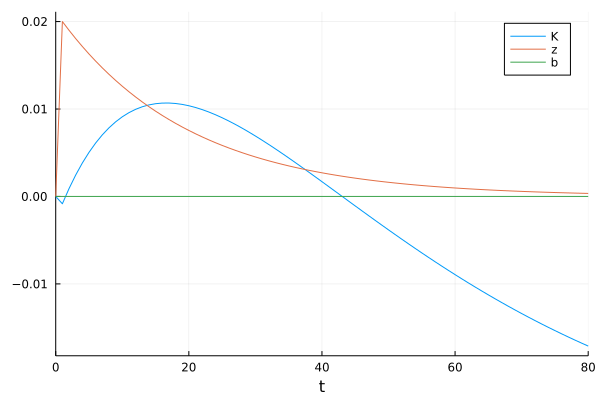

In [63]:
#Generate and plot IRFs
vala = irf(sol2, ϵ01, T) #TFP shock
valb = irf(sol2, ϵ02, T) #laziness shock
plot(vala)

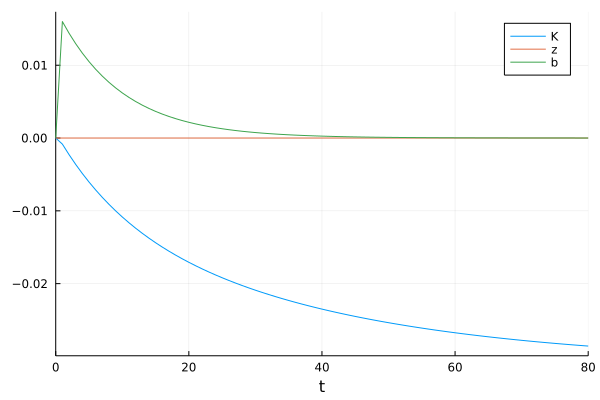

In [64]:
plot(valb)

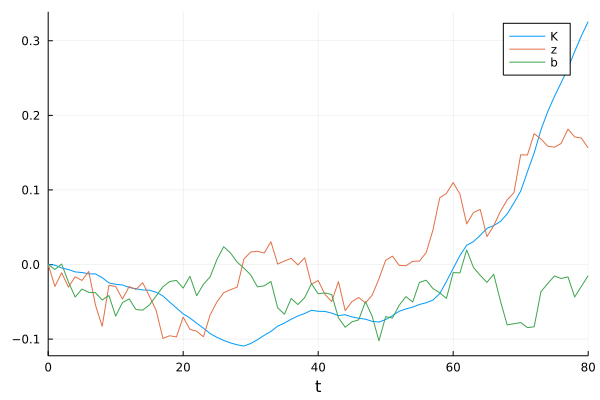

In [65]:
# Simulate T observations from a random initial condition
T = 80
Random.seed!(12345) #Fix seed to reproduce data
x_iv = zeros(n_x) #Start from steady state
# Alternately, draw from ergodic distribution for the initial condition
#x_iv = MvNormal(sol.x_ergodic_var)
problem2 = QuadraticStateSpaceProblem(sol2, x_iv, (0, T))
sim2 = solve(problem2, DirectIteration())
plot(sim2)

In [66]:
#Generate data for estimation
ϵ2 = sim2.W # store the underlying noise in the simulation
# Collapse to simulated observables as a matrix  
z_ms2 = hcat(sim2.z...)

3×81 Matrix{Float64}:
 -0.000784504  -0.016019   …   0.153738    0.151714    0.138063
 -0.00580382   -0.0185785      0.134986    0.133485    0.120913
 -0.00059156    0.0171985     -0.0699783  -0.0638322  -0.0681912

In [67]:
# Turing model definition
@model function ms_kalman2(z, m, p_f, cache, settings, priorparam)
    # priors
    τ ~ Gamma(priorparam[:τ1], priorparam[:τ2])
    ν ~ Gamma(priorparam[:ν1], priorparam[:ν2])
    α ~ Beta(priorparam[:α1], priorparam[:α2])
    ϕ_1 ~ Gamma(priorparam[:ϕ11], priorparam[:ϕ12])
    ϕ_2 ~ Normal(0.0, 75.0)
    ρ_z ~ Beta(priorparam[:ρz1], priorparam[:ρz2])
    ρ_b ~ Beta(priorparam[:ρb1], priorparam[:ρb2])
    s_z ~ InverseGamma(priorparam[:sz1], priorparam[:sz2])
    s_b ~ InverseGamma(priorparam[:sb1], priorparam[:sb2])
    σ_z = s_z/100
    σ_b = s_b/100
    p_d = p_d = (; α, τ, ν, ϕ_1, ϕ_2, ρ_z, ρ_b, σ_z, σ_b)
    T = size(z, 2)
    ϵ_draw ~ MvNormal(m.n_ϵ * T, 1.0) # add noise to the estimation
    ϵ = reshape(ϵ_draw, m.n_ϵ, T)
    # also passes in the p_f for fixed values
    sol = generate_perturbation(m, p_d, p_f, Val(2); cache = cache, settings) # second-order perturbation
    if !(sol.retcode == :Success) # if the perturbation failed, we want to return -infinity for the likelihood and resample
        @addlogprob! -Inf
        return
    end
    x_iv = zeros(sol.n_x) #Replace with ~ MvNormal(sol.x_ergodic_var) to start at ergodic
    problem = QuadraticStateSpaceProblem(sol, x_iv, (0, T), observables = z, noise=ϵ) # utility constructs a QuadraticStateSpaceProblem from the sol
    @addlogprob! solve(problem, DirectIteration()).logpdf #Joint likelihood of z and ϵ
end
settings = PerturbationSolverSettings(; print_level = 0)
p_f = (; Ystar = 1.0, Lstar = 1.0, δ = 0.08, β = 1/((3.0/400)+1), Σ_y = 0.006, Σ_i = 0.004, Σ_l = 0.004) # Fixed parameters
z = z_ms2
turing_model2 = ms_kalman2(z, model_MS_2, p_f, cache2, settings, priorparam) # passing observables from before 

DynamicPPL.Model{typeof(ms_kalman2), (:z, :m, :p_f, :cache, :settings, :priorparam), (), (), Tuple{Matrix{Float64}, PerturbationModel{2, true, Matrix{Float64}, Matrix{Float64}}, NamedTuple{(:Ystar, :Lstar, :δ, :β, :Σ_y, :Σ_i, :Σ_l), NTuple{7, Float64}}, SolverCache{2, Vector{Float64}, Vector{Vector{Float64}}, Matrix{Float64}, Matrix{Float64}, Vector{Float64}, Array{Float64, 3}}, PerturbationSolverSettings{Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, NamedTuple{(:τ1, :τ2, :ν1, :ν2, :α1, :α2, :ϕ11, :ϕ12, :ρz1, :ρz2, :ρb1, :ρb2, :sz1, :sz2, :sb1, :sb2), NTuple{16, Float64}}}, Tuple{}, DynamicPPL.DefaultContext}(ms_kalman2, (z = [-0.0007845039528083208 -0.01601896909188906 … 0.1517144682818629 0.13806296873968246; -0.005803820703900765 -0.01857849282622779 … 0.13348537211994346 0.12091317512172929; -0.0005915595123242661 0.017198534114984475 … -0.06383215143216792 -0.06819121713950364], m = PerturbationModel{2, true, Matrix{Float64}, Matrix{Float64}}(DifferentiableStateSpaceModel

In [84]:
n_samples = 2000
n_adapts = 200
δ = 0.65
alg = NUTS(n_adapts,δ)
println("Sampling.  Ignore any 'rejected due to numerical errors' warnings")  # At this point, Turing can't turn off those warnings
chain_2_joint = sample(turing_model2, alg, n_samples; progress = true)

Sampling.  Ignore any 'rejected due to numerical errors' warnings


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/dchilder/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/dchilder/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /Users/dchilder/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference /Users/dchilder/.julia/packages/Turing/Tpj0b/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /Users/dchilder/.julia/packages/Advanced

Chains MCMC chain (2000×183×1 Array{Float64, 3}):

Iterations        = 201:1:2200
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 4234.32 seconds
Compute duration  = 4234.32 seconds
parameters        = τ, ν, α, ϕ_1, ϕ_2, ρ_z, ρ_b, s_z, s_b, ϵ_draw[1], ϵ_draw[2], ϵ_draw[3], ϵ_draw[4], ϵ_draw[5], ϵ_draw[6], ϵ_draw[7], ϵ_draw[8], ϵ_draw[9], ϵ_draw[10], ϵ_draw[11], ϵ_draw[12], ϵ_draw[13], ϵ_draw[14], ϵ_draw[15], ϵ_draw[16], ϵ_draw[17], ϵ_draw[18], ϵ_draw[19], ϵ_draw[20], ϵ_draw[21], ϵ_draw[22], ϵ_draw[23], ϵ_draw[24], ϵ_draw[25], ϵ_draw[26], ϵ_draw[27], ϵ_draw[28], ϵ_draw[29], ϵ_draw[30], ϵ_draw[31], ϵ_draw[32], ϵ_draw[33], ϵ_draw[34], ϵ_draw[35], ϵ_draw[36], ϵ_draw[37], ϵ_draw[38], ϵ_draw[39], ϵ_draw[40], ϵ_draw[41], ϵ_draw[42], ϵ_draw[43], ϵ_draw[44], ϵ_draw[45], ϵ_draw[46], ϵ_draw[47], ϵ_draw[48], ϵ_draw[49], ϵ_draw[50], ϵ_draw[51], ϵ_draw[52], ϵ_draw[53], ϵ_draw[54], ϵ_draw[55], ϵ_draw[56], ϵ_draw[57], ϵ_draw[58], ϵ_draw[59], ϵ_draw[60], ϵ_draw[61], ϵ_draw[62], ϵ_dra

Run 1: So, obviously that was too short of a run to trust the stats, but at least the code is working, the sampler doesn't error out, and performance looks tolerable. The next step is to go back and increase the number of samples and rerun the whole notebook overnight.

Run 2: Holy moly it works great. All the Rhats look good, the traceplots are beautiful fuzzy caterpillars just like they should be, ESS is looking fantastic, and all the posterior intervals have the pseudotrue parameters well within the range of variation. In other words, everything worked great!

So, this leaves open the question why the first order method was hot garbage while the second order was fine. Barring issues with the Kalman filter, which we've unit tested a fair bit, this leaves the most obvious possible reason as the hypothesis that identification fails at first order because you lose all the nonlinear features, so parameter values influencing those features only (especially the $\phi$s) will be all over the place, losing unimodality and concentration for the posterior and thus forcing it to explore very slowly to deal with the weird geometry (probably one could derive it analytically even given the derivatives and enough time and willpower, but I suspect it's some combination of a ridge and/or a set of regions). HMC notoriously does badly in those settings.  With the second order info to resolve the problem, that goes away, the posterior is nice, and exploration can be fast. Hurray!  

Next steps are to make a few more graphs, and do a more direct comparison with the MS data and method. I suspect we will outperform at second order, though I don't know how much. At first order, their method, which uses more global tempering approaches, may do okay. A nice tentative compromise position for my assessment then will be that gradients are the thing for local exploration, and tempering the thing for global. Both can help in different cases, and there may be gains from combining them.

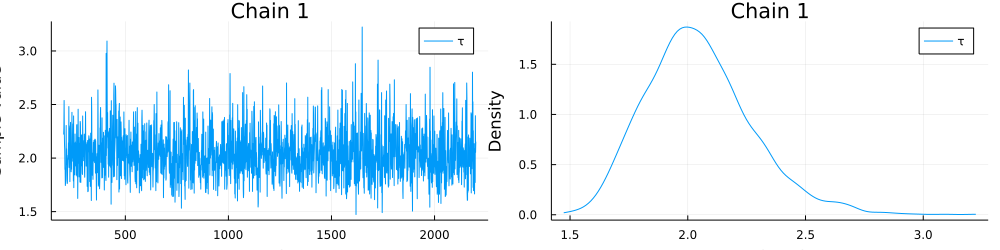

In [85]:
plot(chain_2_joint[["τ"]]; colordim=:parameter, legend=true)

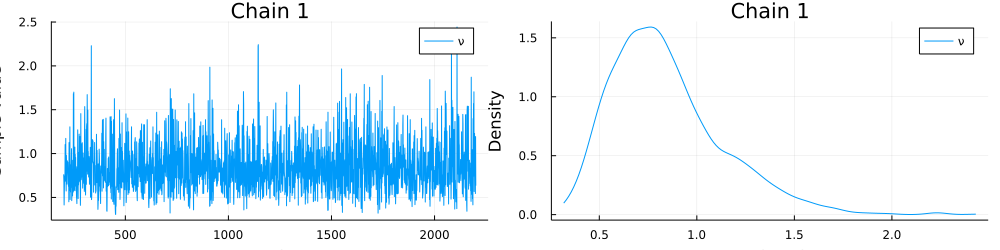

In [86]:
plot(chain_2_joint[["ν"]]; colordim=:parameter, legend=true)

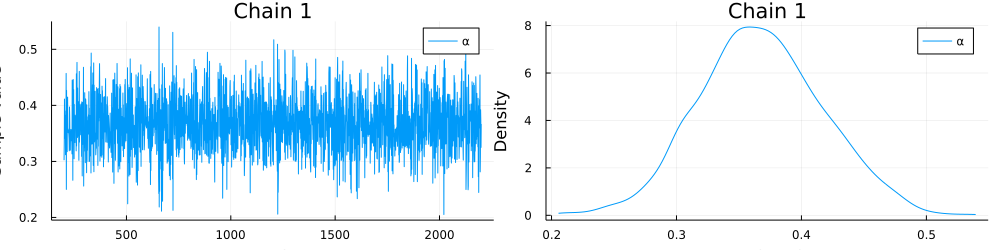

In [87]:
plot(chain_2_joint[["α"]]; colordim=:parameter, legend=true)

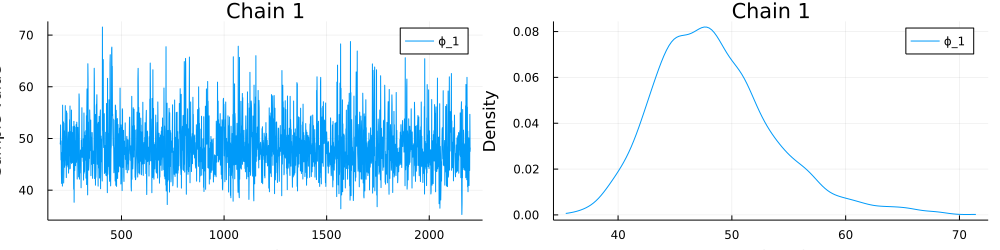

In [88]:
plot(chain_2_joint[["ϕ_1"]]; colordim=:parameter, legend=true)

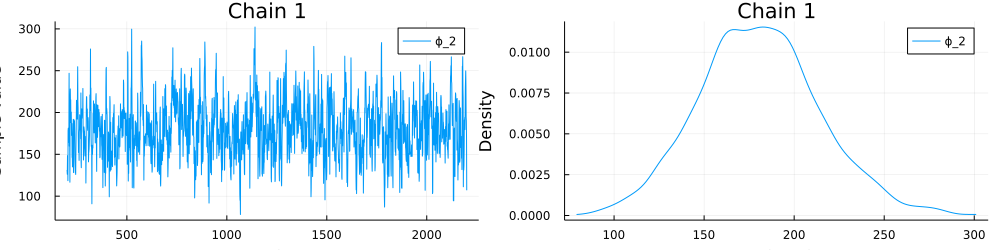

In [89]:
plot(chain_2_joint[["ϕ_2"]]; colordim=:parameter, legend=true)

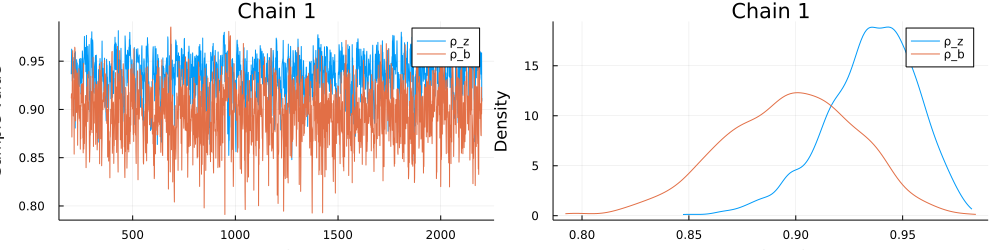

In [90]:
plot(chain_2_joint[["ρ_z", "ρ_b"]]; colordim=:parameter, legend=true)

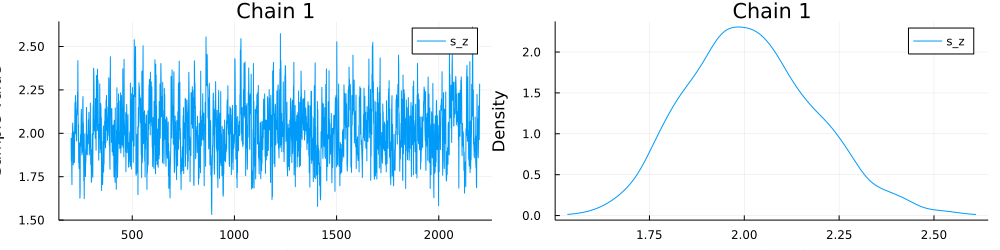

In [91]:
plot(chain_2_joint[["s_z"]]; colordim=:parameter, legend=true)

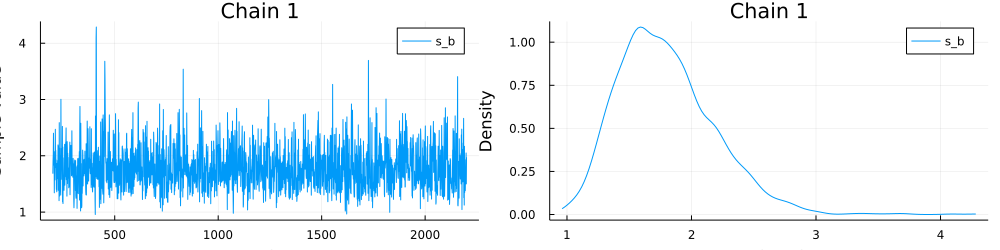

In [92]:
plot(chain_2_joint[["s_b"]]; colordim=:parameter, legend=true)

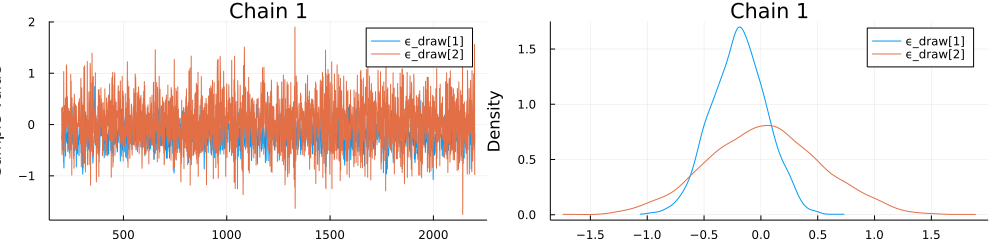

In [93]:
plot(chain_2_joint[["ϵ_draw[1]","ϵ_draw[2]"]]; colordim=:parameter, legend=true)

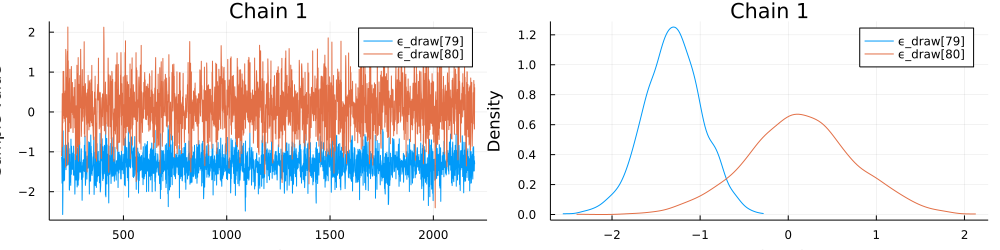

In [94]:
plot(chain_2_joint[["ϵ_draw[79]","ϵ_draw[80]"]]; colordim=:parameter, legend=true)

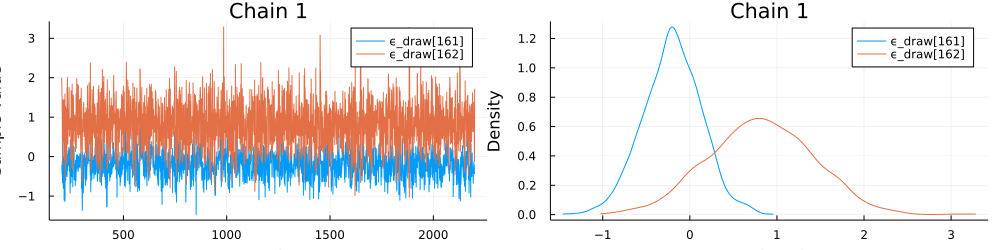

In [99]:
plot(chain_2_joint[["ϵ_draw[161]","ϵ_draw[162]"]]; colordim=:parameter, legend=true)

In [122]:
ϵ_chain1 = sort(chain_2_joint[:, symbollist[2, :], 1], lt = (x,y) -> symbol_to_int(x) < symbol_to_int(y))
tmp1 = describe(ϵ_chain1)
tmp1[2]

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

   ϵ_draw[2]   -0.9381   -0.3104    0.0264    0.3628    1.0178
   ϵ_draw[4]   -1.5972   -0.8231   -0.4366   -0.0123    0.7961
   ϵ_draw[6]   -0.9461   -0.1565    0.2605    0.6727    1.4835
   ϵ_draw[8]   -2.8572   -2.0371   -1.6266   -1.2187   -0.4634
  ϵ_draw[10]   -1.8367   -1.0186   -0.5846   -0.1613    0.6220
  ϵ_draw[12]   -1.9959   -1.1498   -0.7420   -0.3321    0.4570
  ϵ_draw[14]   -1.5777   -0.7870   -0.3654    0.0248    0.8281
  ϵ_draw[16]   -1.8135   -1.0006   -0.5576   -0.1046    0.7474
  ϵ_draw[18]   -2.0639   -1.2528   -0.7949   -0.3464    0.5061
  ϵ_draw[20]   -1.4852   -0.6863   -0.2607    0.1931    0.9994
  ϵ_draw[22]   -2.0031   -1.1797   -0.7592   -0.3224    0.4427
  ϵ_draw[24]   -2.1715   -1.3692   -0.9236   -0.5173    0.2931
  ϵ_draw[26]   -1.4428   -0.6932   -0.2825    0.1650    0.9523
  ϵ_draw[28]   -2.0819   -1.2912   -0.8783

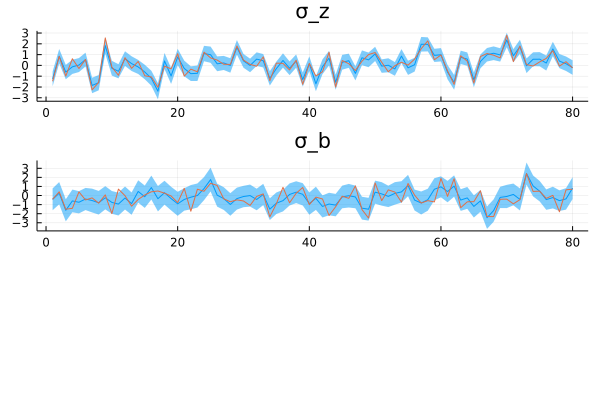

In [124]:
#Plot true and estimated epsilon series

# epsilons
symbol_to_int(s) = parse(Int, replace(string(s), "ϵ_draw["=>"", "]"=>""))
symbollist = reshape([Symbol("ϵ_draw[$a]") for a in 1:162], 2, 81)
labels = ["σ_z", "σ_b"]
plots = []

# Import the true shock values
ϵ_true = ϵ2'

for i in 1:2
    ϵ_chain = sort(chain_2_joint[:, symbollist[i, :], 1], lt = (x,y) -> symbol_to_int(x) < symbol_to_int(y))
    tmp = describe(ϵ_chain)
    ϵ_mean = tmp[1][:, 2]
    ϵ_se = tmp[1][:, 3]
            
    # Plot and save
    ϵ_plot = plot(ϵ_mean[2:end], ribbon=2 * ϵ_se[2:end], title = labels[i])
    ϵ_plot = plot!(ϵ_true[:, i], label="True values")
    push!(plots, ϵ_plot)
end
ϵ_plot = plot(plots[1], plots[2], layout = (4, 1), legend=false)

We do a decent job recovering the true shocks generating the process, with the unobserved true values generally falling within the $\pm 2$ standard deviation confidence bands.

In [125]:
#Save chain
currentdir = pwd()
serialize(joinpath(currentdir, "chainMS_2.jls"), chain_2_joint)